In [1]:
import re
import os
import numpy as np
import math
import pickle
import matplotlib.pyplot as plt
import random
from nltk import FreqDist
from nltk.util import ngrams 
from zipfile import ZipFile
from kneebow.rotor import Rotor
from kneed import KneeLocator
from sklearn.feature_extraction.text import CountVectorizer

Load 2 million word corpus

In [2]:
corpus = []

archive = ZipFile('corpus2mw.zip', 'r')

fileList = archive.namelist()
for file in fileList:
    corpus.append((archive.read(file)).decode('UTF-8'))


Process text (separate special characters from words)

In [3]:
regexp = re.compile('[\w \-]') 

def processText(corpus):
    corp = []
    for text in corpus:
        listT = list(text)
        i = 0
        for  c in listT:
            if (not regexp.search(c) and not listT[i-1]==' ') or not regexp.search(listT[i-1]) and regexp.search(c):
                listT.insert(i, ' ')
            i +=1
        corp.append(''.join(listT))
    return corp

readPickle = False
if readPickle:
    with open('corpusList', 'rb') as fp:
        corpus = pickle.load(fp)
else: 
    corpus =  processText(corpus)

    with open('corpusList', 'wb') as fp:
            pickle.dump(corpus, fp)

Compute ngrams

In [4]:
def compute_freq_doc(text, minG, maxG):
   freq_dist = FreqDist()
   if len(text) > 1:
       tokens = text.strip().split()
       for i in range(minG, maxG+1):
           grams = ngrams(tokens, i)
           freq_dist.update(grams)

   return dict(freq_dist)


def compute_freq_corpus(minG, maxG):
   freq_dist = FreqDist()
   for text in corpus:
        if len(text) > 1:
            tokens = text.strip().split()
            for i in range(minG, maxG+1):
                grams = ngrams(tokens, i)
                freq_dist.update(grams)

   return dict(freq_dist)


freq_dict = compute_freq_corpus(1, 8)
filtered_dict = {' '.join(key):val for key, val in freq_dict.items() if val > 1}

In [5]:
filtered_dict_sorted= sorted(filtered_dict.items(), key=lambda x: len(x[0].split()), reverse=True)

53190
53303
53186


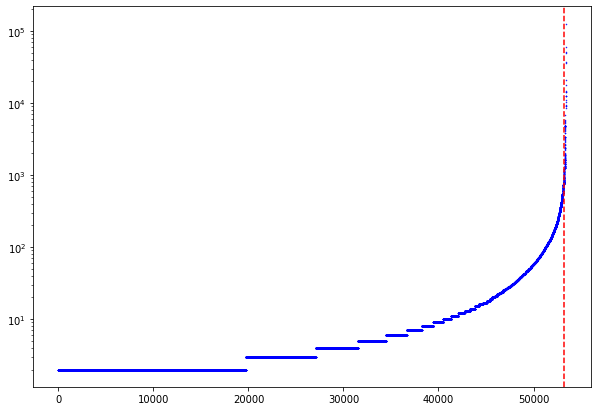

In [6]:

#unigrams
vectorizer = CountVectorizer(token_pattern=r'\w+')
vec_fit = vectorizer.fit_transform(corpus)
single_word_list = vectorizer.get_feature_names()
single_count_list = np.asarray(vec_fit.sum(axis=0))[0]
single_freq_dict = dict(zip(single_word_list,single_count_list))

single_freq_dict = {key:val for key, val in single_freq_dict.items() if val > 1}
single_freq_dict = {k: v for k, v in sorted(single_freq_dict.items(), key=lambda item: item[1])}
values = np.fromiter(single_freq_dict.values(), dtype=float)
stop_words_list = np.stack((np.arange(0, len(single_freq_dict)), values), axis = -1)
list_of_counts = list(single_freq_dict.items())


rotor = Rotor()
rotor.fit_rotate(stop_words_list)
elbow_idx = rotor.get_elbow_index()
print(elbow_idx)  
#rotor.plot_elbow()

kn = KneeLocator(stop_words_list[:,0] ,stop_words_list[:,1], curve='convex', direction='increasing')
print(int(kn.knee))

stop = 0
deltaX = 200
for idx, i, j in zip(range(0, len(values)), values, values[deltaX:]):
    if((j-i)>stop): stop = idx
print(stop)


fig = plt.figure()
ax = plt.gca()
ax.scatter(stop_words_list[:,0] ,stop_words_list[:,1] , s=1,c='blue', marker='.')
ax.set_yscale('log')
#ax.set_xscale('log')
fig.set_size_inches(10, 7)
plt.axvline(x=elbow_idx, color='r', linestyle='--')


#relev_exp_unigrams = list_of_counts[:elbow_idx] #not really necessary
stop_words_unigrams = list_of_counts[stop:]

LocalMax

In [7]:
expressions_count={}

for key, val in filtered_dict_sorted:
    expressions_count[key] = val

In [10]:
stop_words=[]

for key, val in stop_words_unigrams:
    stop_words.append(key)

In [11]:
stop_words

['east',
 'age',
 'located',
 'because',
 '2009',
 'like',
 'long',
 'march',
 'found',
 'home',
 'september',
 'line',
 '2011',
 'station',
 '2008',
 'end',
 'international',
 'system',
 'band',
 'if',
 '0',
 'any',
 '2010',
 'career',
 'general',
 'use',
 '7',
 'won',
 'town',
 '10',
 'so',
 'west',
 '000',
 'now',
 'same',
 'based',
 'day',
 'game',
 'house',
 'population',
 'government',
 'company',
 'several',
 '6',
 'john',
 'following',
 'each',
 'played',
 'released',
 'league',
 'county',
 'music',
 'called',
 'four',
 'work',
 'life',
 'district',
 'de',
 'name',
 'number',
 'until',
 'will',
 'area',
 'group',
 'since',
 'history',
 'series',
 'north',
 'against',
 'album',
 'people',
 'family',
 'them',
 '4',
 'south',
 'early',
 'including',
 'born',
 'however',
 'high',
 'through',
 'both',
 'film',
 'before',
 'states',
 'became',
 'war',
 'well',
 '5',
 'being',
 'than',
 'united',
 'these',
 'team',
 'second',
 'university',
 'season',
 'no',
 'american',
 'part',
 'i'

In [16]:
poss_re={}

for key, val in filtered_dict_sorted:
    words= key.split()
    n= len(words)
    if len(words) > 1:    
        ownpref=''
        ownsuf=''
        for i in range(0,n):
            if i==0:
                ownpref += key.split(' ')[i]
            elif i==n-1:
                ownsuf += key.split(' ')[i]
            else:
                ownpref += ' ' + key.split(' ')[i]
                ownsuf += key.split(' ')[i] + ' '
        xpref= expressions_count[ownpref]
        xsuf= expressions_count[ownsuf]
        scpg= val**2 /(xpref * xsuf)
        diceg = 2 * val / (xpref + xsuf)

        poss_re[key] = {'n':n,  'freq': val, 'scpg': scpg, 'diceg': diceg,'xpref': ownpref, 'xsuf': ownsuf}


In [25]:
points=['.',',','?','(',')','!','@','&','^','~','|','>','<', '%', '$', '[', ']', '{', '}', ':', ';', '-','a','s', '_', '+', '=', '*', '\\', '\'', '\"', '`', '#', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '/', '-', "'", 't']
relevant_expressions={}
res=[]

for key, val in poss_re.items():
    if val['n'] > 2:
        #print(val['n'], 'ngram')
        
        words = key.split()
        if words[0].lower() in stop_words:
            continue
        if words[-1].lower() in stop_words:
            continue
        if val['freq'] <= 2:
            continue
        grams = key.split()
        puntcount = 0
        for g in grams:
            if g in points:
                puntcount+=1
        if puntcount!=0:
            continue
        #best x
        try:
            xpref = poss_re[val['xpref']]['scpg']
            xsuf = poss_re[val['xsuf']]['scpg']
            bestxscp = max(xpref, xsuf)
            
            xpref = poss_re[val['xpref']]['diceg']
            xsuf = poss_re[val['xsuf']]['diceg']
            bestxdice = max(xpref, xsuf)
        except:
            continue
        
        
        #best y
        bestyscp=1    
        for keyy, valy in poss_re.items():
            if key in keyy and valy['n'] == val['n']+1:
                if valy['scpg']<bestyscp:
                    bestyscp=valy['scpg']
                    
        bestydice=1    
        for keyy, valy in poss_re.items():
            if key in keyy and valy['n'] == val['n']+1:
                if valy['diceg']<bestydice:
                    bestydice=valy['diceg']

        #see if is relevant
        if (val['scpg']-0.6)>(bestxscp+bestyscp)/2 and (val['diceg']-0.6)>(bestxdice+bestydice)/2:
            print(key)
            relevant_expressions[key]={'n':val['n'], 'freq': val['freq'], 'scpg': val['scpg'], 'xscp':bestxscp, 'yscp':bestyscp, 'diceg': val['diceg'], 'xdice':bestxdice, 'ydice':bestydice}
            res.append(key)
    
    else:
        words = key.split()
        if words[0].lower() in stop_words:
            continue
        if words[-1].lower() in stop_words:
            continue
        if val['freq'] <= 2:
            continue
        grams = key.split()
        puntcount = 0
        for g in grams:
            if g in points:
                puntcount+=1
        if puntcount!=0:
            continue
        
        #print(val['n'], 'bigram')
        for keyy, valy in poss_re.items():
            if key in keyy and valy['n'] == val['n']+1:
                if valy['scpg']<bestyscp:
                    bestyscp=valy['scpg']
                    
        bestydice=1    
        for keyy, valy in poss_re.items():
            if key in keyy and valy['n'] == val['n']+1:
                if valy['diceg']<bestydice:
                    bestydice=valy['diceg'] 
        
        if (val['scpg']-0.6)>bestyscp and (val['diceg']-0.6)>bestydice:
            #print(key)
            relevant_expressions[key]={'n':val['n'], 'freq': val['freq'], 'scpg': val['scpg'], 'yscp':bestyscp, 'diceg': val['diceg'], 'ydice':bestydice}
            res.append(key)

According to the United States Census
added to the National Register
19th and early 20th
1950s and early 1960s
Rio de Janeiro
Atlantic Coast Conference
Hall of Fame
Bocas del Toro
per square mile
Hispanic or Latino
above sea level
Newfoundland and Labrador
Major League Baseball
Saturdays and Sundays
Bosnia and Herzegovina
Trinidad and Tobago
25 to 44
45 to 64
Greater Poland Voivodeship
Cirque du Soleil
Buffy the Vampire
Best Foreign Language
Prince Edward Island
mid to late
Shivani and Mohini
Pan American Games
Australian Capital Territory
Eurovision Song Contest
except where noted
Antigua and Barbuda
Environmental Protection Agency
Central African Republic
above mean sea
Jammu and Kashmir
Chief Operating Officer
Ho Chi Minh
subtropical or tropical
Talk ‘ N
leave of absence
Los Angeles
Nova Scotia
Notre Dame
Hong Kong
hip hop
alma mater
Puerto Rico
Las Vegas
Buenos Aires
Lok Sabha


In [ ]:
res

In [ ]:
print('Precision')
print(len(relevant_expressions)/len(poss_re))



recallList = []
for i in range(0,200):
    recallList.append(random.choice(poss_re.keys()))
countR = 0
for k in recallList:
    if k in relevant_expressions.keys():
        countR += 1
print('Recall')
print(countR/200)

In [ ]:
with open('REList', 'wb') as fp:
    pickle.dump(relevant_expressions, fp)
   
with open('REList', 'rb') as fp:
    relevant_expressions = pickle.load(fp)

Explicit and Implicit Keywords

In [ ]:
def count_RE_in_doc(RE):
    count = 0
    for text in corpus:
        if RE in text:
            count += 1
    
    return count

def freq(RE,doc):
    freq_dict = compute_freq_doc(doc, len(RE.split()), len(RE.split()))
    if len(RE.split()) > 1:
        freq_dict = {' '.join(key):val for key, val in freq_dict.items()}
    else:
        freq_dict = {''.join(key):val for key, val in freq_dict.items()}
    return freq_dict[RE]


def tf_idf(RE, doc_idx):
    doc = corpus[doc_idx]
    
    freq_RE = freq(RE,doc)
    
    return (freq_RE/len(doc.strip().split()))*math.log(len(corpus)/count_RE_in_doc(RE))

def findWholeWord(w):
    return re.compile(r'\b({0})\b'.format(re.escape(w))).search

def calc_prob(word):
    sum_p = 0
    for doc in corpus:
        if findWholeWord(word)(doc): 
            sum_p += freq(word, doc)/len(doc.strip().split())
    return (1/len(corpus))*sum_p

def calc_cov(A,B):
    probA = calc_prob(A)
    probB = calc_prob(B)
    sum_p = 0
    for doc in corpus:
        if findWholeWord(A)(doc) and findWholeWord(B)(doc):
            sum_p += (freq(A, doc)/len(doc.strip().split())-probA)*(freq(B, doc)/len(doc.strip().split())-probB)
    
    return (1/(len(corpus)-1))*sum_p

def correlation(A,B):
    return calc_cov(A, B)/(math.sqrt(calc_cov(A, A))*math.sqrt(calc_cov(B, B)))

def get_distances(A,B,doc):
    closest = 0
    farthest = 0
    
    listA = A.split()
    listB = B.split()
    listDoc = doc.strip().split()
    
    idx_pos_A_1 = [ i for i in range(len(listDoc)) if listDoc[i] == listA[0] ]
    idx_pos_A_2 = [ i for i in range(len(listDoc)) if listDoc[i] == listA[-1] ]
    idx_pos_B_1 = [ i for i in range(len(listDoc)) if listDoc[i] == listB[0] ]
    idx_pos_B_2 = [ i for i in range(len(listDoc)) if listDoc[i] == listB[-1] ]
    
    idx_pos_A_1_copy = idx_pos_A_1
    idx_pos_A_2_copy = idx_pos_A_2
    idx_pos_B_1_copy = idx_pos_B_1
    idx_pos_B_2_copy = idx_pos_B_2
    
    for pos, idx in enumerate(idx_pos_A_1_copy):
        for i, elem in enumerate(listA):
            if listDoc[idx+i] != elem:
                    idx_pos_A_1.pop(pos)
                    break
                
    for pos, idx in enumerate(idx_pos_A_2_copy):
        for i, elem in enumerate(reversed(listA)):
            if listDoc[idx-i] != elem:
                    idx_pos_A_2.pop(pos)  
                    break
                           
    for pos, idx in enumerate(idx_pos_B_1_copy):
        for i, elem in enumerate(listB):
            if listDoc[idx+i] != elem:
                    idx_pos_B_1.pop(pos) 
                    break
            
                
    for pos, idx in enumerate(idx_pos_B_2_copy):
        for i, elem in enumerate(reversed(listB)):
            if listDoc[idx-i] != elem:
                    idx_pos_B_2.pop(pos)    
                    break
    
    listF = []
    
    for a in idx_pos_A_1:
        for b in idx_pos_B_2:
            listF.append(a-b)
    for a in idx_pos_A_2:
        for b in idx_pos_B_1:
            listF.append(b-a)
    listF = [ i for i in listF if i > 0 ]
    
    if len(listF) == 0: return 1

    return min(listF)/max(listF)
  
def IP(A,B):
    count = 0
    sum_dist = 0 
    for i, doc in enumerate(corpus):
        if findWholeWord(A)(doc) and findWholeWord(B)(doc):
            count += 1
            sum_dist += get_distances(A, B, doc)
        
    return 1-(1/count)*sum_dist
        
       
def sem_prox(A,B):
    return correlation(A, B)*math.sqrt(IP(A,B))

def occur_in_any_doc(A,B):
    for doc in corpus:
        if findWholeWord(A)(doc) and findWholeWord(B)(doc):
            return True
    return False

def calc_comp_medio(RE):
    count = 0
    listRE = RE.split()
    for w in listRE:
        count += len(w)
    return count/len(listRE)
    
def score_explicit(doc_idx):
    doc = corpus[doc_idx]
   
    #unigrams
    uni_dict = compute_freq_doc(doc, 1, 1)
    uni_dict = {''.join(key):val for key, val in uni_dict.items()}

    for k in uni_dict.keys():
        uni_dict[k] = tf_idf(k,doc_idx) * calc_comp_medio(k)
    top5_uni = dict(sorted(uni_dict.items(), key=lambda x: x[1], reverse=True)[:5])
    #relevant expressions
    re_dict = {}
    for k in relevant_expressions.keys():
        if k in doc:
            re_dict[k] = relevant_expressions[k]['freq']
    
    
    for k in re_dict.keys():
        re_dict[k] = tf_idf(k,doc_idx) * calc_comp_medio(k)
    top5_re = dict(sorted(re_dict.items(), key=lambda x: x[1], reverse=True)[:5])
    
    return top5_uni , top5_re if len(re_dict) != 0 else 'No REs in the document'
    
def score_implicit(doc_idx):
    doc = corpus[doc_idx]
    #relevant expressions
    re_dict_in = {}
    re_dict_out = {}
    for k in relevant_expressions.keys():
        if k in doc:
            re_dict_in[k] = relevant_expressions[k]['freq']
        else:
            re_dict_out[k] = relevant_expressions[k]['freq']
    
    if len(re_dict_in) == 0: return 'No REs in the document'
    
    for k in re_dict_in.keys():
        re_dict_in[k] = tf_idf(k,doc_idx) * calc_comp_medio(k)
    top10_re = dict(sorted(re_dict_in.items(), key=lambda x: x[1], reverse=True)[:10])
    
    scores = {}
    for k in re_dict_out.keys():
        score = 0
        for i, v in enumerate(top10_re):
            if occur_in_any_doc(k, v):
                score += sem_prox(k, v)/(i+1)
        scores[k] = score
    top10_scores = dict(sorted(scores.items(), key=lambda x: x[1], reverse=True)[:10])
    return top10_scores

#check document length
len_docs = {}
for i, doc in enumerate(corpus):
    len_docs[i] = len(doc.strip().split())
    

#print(sorted(len_docs.items(), key=lambda x: x[1], reverse=True))

In [ ]:
print("Doc 303") 
print(score_explicit(303))    
print(score_implicit(303))

print("Doc 1104")
print(score_explicit(1104))    
print(score_implicit(1104))

print("Doc 1230") 
print(score_explicit(1230))    
print(score_implicit(1230))

print("Doc 1595")
print(score_explicit(1595))    
print(score_implicit(1595)) 

print("Doc 2120")
print(score_explicit(2120))    
print(score_implicit(2120))

({'PricewaterhouseCoopers': 0.22796157691837088, 'integrative': 0.22796157691837088, 'Randolph': 0.22393010018965329, 'qigong': 0.2159411323537057, 'criticizing': 0.1919951031822125}, 'No REs in the document')
No REs in the document
